<a href="https://colab.research.google.com/github/vermashivam679/YouTube_comments_NLP/blob/master/youtube_flying_beast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Stanza

[Stanza](https://github.com/stanfordnlp/stanza) is a PyTorch based python library that provides language-agnostic neural pipelines for Natural Language Processing developed by the [Stanford NLP group](https://nlp.stanford.edu/). See the official documentaion [here](https://stanfordnlp.github.io/stanza/).


In [ ]:
!pip install stanza

     |████████████████████████████████| 194kB 4.8MB/s 


[](https://pypi.org/project/googletrans/)

## Googletrans

[googletrans](https://pypi.org/project/googletrans/) is a wrapper python library that provides easy access to the [Google Translate API](https://cloud.google.com/translate/docs). I used it to autodetect the source language and translated text to english as the destination language. 

In [ ]:
!pip install googletrans

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 931kB 13.0MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=935a6f439519efb06b750e14c8070c138e8c2ff78d28ee1f586dcb2246a979a7
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=3251903ae45b9ef44cff94f47872ad53a4139441b7eb7297a18bdd387255d631
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


## [Transformers](https://github.com/huggingface/transformers)

- [Transformers](https://huggingface.co/transformers/index.html) is a state-of-the-art library for Natural Language Processing(NLP). 
- It provides general-purpose architectures (e.g. BERT, GPT-2) for Natural Language Understanding (NLU) & Natural Language Generation (NLG). 
- It has more than 32 pretrained models in more than 100 languages. 
- It provides pipelines for common use-cases such as Sentiment Analysis, Named Entity Recognition (NER), Extractive Question Answering, text summarization, etc.


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 4.6MB/s 
     |████████████████████████████████| 3.0MB 22.3MB/s 
     |████████████████████████████████| 890kB 56.6MB/s 
     |████████████████████████████████| 1.1MB 54.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fff37a838e7c77a6ed56655eb8c39c3801e02e367fbe62dbabb4ce91a03e7be9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
## Importing all libraries

from googleapiclient.discovery import build

import pandas as pd
import numpy as np

import os
import time
from collections import Counter
from tqdm import tqdm
import multiprocessing
import pickle
import matplotlib.pyplot as plt
% matplotlib inline
import pickle

import transformers
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModelForQuestionAnswering, pipeline

import torch

import spacy
import re
import gensim.corpora as corpora
import gensim
from gensim import matutils, models
from wordcloud import WordCloud

from googletrans import Translator

import stanza

In [ ]:
## Checking Compute Configuration
if torch.cuda.is_available():       
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("tpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'

In [ ]:
youtube = build(API_SERVICE_NAME, API_VERSION, developerKey='<get your own API key from youtube>', cache_discovery=False)

In [ ]:
def get_search_videos(search_query):
  """
  Given a search query (`search_query`) extracts the videoid, video title & description of 30 most relevant videos returned by YouTube search engine
  
  Parameters
  -------------
  search_query : (str) 
      search query
  
  Returns
  -------------
  (pandas.DataFrame) DataFrame having videoid, video title & description of 30 most relevant videos returned by YouTube search engine.
  """
  request = youtube.search().list(
      part="snippet",
      maxResults=30,
      q= search_query
  )
  response = request.execute()

  search_data = pd.DataFrame({'videoId': list(map(lambda x: x['id']['videoId'] if 'videoId' in x['id'].keys() else 0, response['items'])),
  'title': list(map(lambda x: x['snippet']['title'], response['items'])),
  'description': list(map(lambda x: x['snippet']['description'], response['items']))})

  search_data = search_data[search_data.videoId.values!=0]
  temp = set(list(map(lambda x: x['id']['channelId'] if 'channelId' in x['id'].keys() else '', response['items'])))-{''}
  if len(temp)==1:
    search_data.channelId = list(temp)[0]


  stats = list(map(lambda x: get_stats_descp(x), search_data['videoId']))
  for name in stats[0].keys():
    search_data[name] = list(map(lambda x: x[name] if name in x.keys() else 0, stats))
  return  search_data

In [ ]:
# get playlists of a channel. You have to take car eof that the resonse has more than some limit. so just be careful

def get_playlists(channelid):
  """
  Given `channelid` extracts the playlistid, playlist title & count of videos in that playlist
  
  Parameters
  -------------
  channelid : (str) 
      Channel id
  
  Returns
  -------------
  (pandas.DataFrame) DataFrame having playlistid, playlist title & count of videos in that playlist.
  """
  request = youtube.playlists().list(
      part = ['snippet', 'contentDetails'], 
      channelId = channelid,
      maxResults = 1000
  )
  response = request.execute()

  my_playlist = pd.DataFrame({'playlist_id': list(map(lambda x: x['id'], response['items'])),
  'title': list(map(lambda x: x['snippet']['title'], response['items'])),
  'count': list(map(lambda x: x['contentDetails']['itemCount'], response['items']))})

  return my_playlist


In [ ]:
def get_songs_playlist(pid):
  """
  Given playlist id (`pid`) extracts the videoid, video title & description of videos in that playlist
  
  Parameters
  -------------
  pid : (str) 
      Playlist id
  
  Returns
  -------------
  (pandas.DataFrame) DataFrame having videoid, video title & description of videos in that playlist.
  """

  request = youtube.playlistItems().list(
      part = ['snippet', 'contentDetails'], 
      playlistId = pid,
      maxResults = 50
  )
  response = request.execute()

  playlist_data = pd.DataFrame({'videoId': list(map(lambda x: x['contentDetails']['videoId'], response['items'])),
  'title': list(map(lambda x: x['snippet']['title'], response['items'])),
  'description': list(map(lambda x: x['snippet']['description'], response['items']))})

  while 'nextPageToken' in set(response.keys()):
    request = youtube.playlistItems().list(
      part = ['snippet', 'contentDetails'], 
      playlistId = pid,
      maxResults = 50,
      pageToken = response['nextPageToken']
    )
    response = request.execute()
    temp = pd.DataFrame({'videoId': list(map(lambda x: x['contentDetails']['videoId'], response['items'])),
      'title': list(map(lambda x: x['snippet']['title'], response['items'])),
      'description': list(map(lambda x: x['snippet']['description'], response['items']))})
    playlist_data = pd.concat((playlist_data, temp))

  stats = list(map(lambda x: get_stats_descp(x), playlist_data['videoId']))
  for name in stats[0].keys():
    playlist_data[name] = list(map(lambda x: x[name], stats))  
  return(playlist_data)

In [ ]:
# Why dislike button doesn't need to be taken into account.
# https://www.youtube.com/watch?v=7vu2xKIhvdw
def get_vid_comments(vid):
  """
  Given video id (`vid`) extracts the comments, likecount and latest updated time of comments
  
  Parameters
  -------------
  vid : (str) 
      Video id
  
  Returns
  -------------
  (pandas.DataFrame) DataFrame having comments, likecount & latest updated time of comments.
  """

  request = youtube.commentThreads().list(
      part='snippet',
      videoId = vid,
      maxResults = 50
  )
  response = request.execute()

  comment_data = pd.DataFrame({'comment': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['textDisplay'], response['items'])),
  'likecount': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['likeCount'], response['items'])),
  'updatedAt': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['updatedAt'], response['items']))})


  while 'nextPageToken' in set(response.keys()):
    request = youtube.commentThreads().list(
      part = 'snippet', 
      videoId = vid,
      maxResults = 50,
      pageToken = response['nextPageToken']
    )
    response = request.execute()
    temp = pd.DataFrame({'comment': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['textDisplay'], response['items'])),
      'likecount': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['likeCount'], response['items'])),
      'dislikecount': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['dislikeCount'], response['items'])),
      'updatedAt': list(map(lambda x: x['snippet']['topLevelComment']['snippet']['updatedAt'], response['items']))})
    comment_data = pd.concat((comment_data, temp))
  return(comment_data)

In [ ]:
def get_stats_descp(vid):
  """
  Given video id (`vid`) extracts the viewCount,	likeCount,	dislikeCount,	favoriteCount & commentCount on the video
  
  Parameters
  -------------
  vid : (str) 
      Video id
  
  Returns
  -------------
  (dict) A dictionary containing view count, like count, dislike count, favorite count & comment count on the video.
  """

  request = youtube.videos().list(
          part="snippet,contentDetails,statistics",
          id=vid
      )
  response = request.execute()

  x = response['items'][0]['statistics']
  return x

In [ ]:
spacy_nlp = spacy.load("en_core_web_sm")
translator = Translator()

# Attribution for this function to Varada Kolhatkar, Assistant Professor of Teaching at UBC
def preprocess(text, 
               min_token_len = 2 , 
               irrelevant_pos = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE'] ,
               for_bert=False): 
    """
    Given text, minimum token length(`min_token_len`), and irrelevant parts of speech(`irrelevant_pos`) carry out preprocessing of the text 
    and return a preprocessed string. Removes emails, trailing white spaces & other wierd characters. 
    Automatically translate the data to english language.
    
    Parameters
    -------------
    text : (str) 
        the text to be preprocessed
    min_token_len : (int) 
        min_token_length required
    irrelevant_pos : (list) 
        a list of irrelevant pos tags
    
    Returns
    -------------
    (str) the preprocessed text
    """
    # Remove Emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Replace a sequence of whitespaces by a single whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove other strange characters
    text = re.sub(r'''[\*\~]+''', "", text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    if for_bert:
        return text

    try:
      trans_text = translator.translate(text).text
    except:
      trans_text = text
    
    doc = spacy_nlp(trans_text)
    clean_text = []
    
    for token in doc:
        if (token.is_stop == False # Check if it's not a stopword
            and token.is_alpha # Check if it's an alphanumerics char
            and not token.like_email # Check if the token is an not like email
            and not token.like_url  # Check if the token is an not like a url 
            and len(token) > min_token_len): # Check if the word meets minimum threshold
            # and token.pos_ not in irrelevant_pos): # Check if the POS is in the acceptable POS tags
            # lemma = token.lemma_ # Take the lemma of the word
            lemma = token.text
            clean_text.append(lemma)  
    clean_text = " ".join(clean_text)
    return clean_text

In [ ]:
def get_comments(playlist_data):
  """
  Takes a pd.DataFrame returned by `get_search_videos()` & `get_songs_playlist()` and extracts comments for each video. 
  Sleeps for 10 seconds after extracting comments for each video.
  
  Parameters
  -------------
  playlist_data : (pd.DataFrame) 
      Pandas DataFrame containing the video id of videos
  
  Returns
  -------------
  (pd.DataFrame) Comments data for all the videos in the `playlist_data`.
  """

  comments_data = pd.DataFrame()
  with tqdm(total = playlist_data.shape[0]) as pbar:
    for i in range(playlist_data.shape[0]):
      vid = playlist_data.iloc[i,0]
      try:
        temp = get_vid_comments(vid)
        temp['song'] = playlist_data.iloc[i,1]
        comments_data = pd.concat((comments_data, temp))
        time.sleep(10)
      except:
        time.sleep(10)

      pbar.update()
  return comments_data

## Search YouTube

In [ ]:
## Input the seach query
search_query = 'flying beast'

In [ ]:
search_data = get_search_videos(search_query)
search_data

,videoId,title,description,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
1,fHDhsL-w2Ko,Rashi finally does the &#39; Dheeme Dheeme &#3...,Vlog # 137 https://bit.ly/2C6n9h9 The Derma co...,484740,117393,1215,0,5195
2,zqNSKl2xpYU,No Phone | No TV from now on,Vlog # 137 Gaming channel https://www.youtube....,2032617,206133,2412,0,6869
3,7m72_3Vp9ew,Rashi got a New Friend and She Forgot Us,Vlog # 136 join us LIVE https://www.youtube.co...,1861426,174318,1832,0,16044
4,rKyvj-9MzOo,Rashi. went out First time after Lockdown,Vlog # 135 went out with rashii after soo loon...,2425361,223512,2320,0,10197
5,PeBuyDAycck,Making the Original Cover with Rasbhari,Vlog # 134 PubG stream on https://www.youtube....,1977474,194419,2497,0,9474
6,pGCLdH2b5r4,Going for my Exit Formalities with the Company,Vlog # 133 LIVE STREAM https://www.youtube.com...,2880992,229593,2493,0,7044
7,GQMYYtK8eWM,IIT Chemistry vs BSc Chemistry | OP,Vlog # 133 Exhibit magazine. vote for me in th...,2102352,191978,2802,0,16126
8,w3sxAN8kQ1Y,Daughter does Dad&#39;s makeup..,Vlog # 132 vote for me in Health and Fitness c...,1961013,193587,2240,0,6682
9,PxxNf_KQG04,The Struggling Beauty Blogger !!,Vlog # 120 uploaded this vlog from hotspot. wi...,2159667,206748,2518,0,7888
10,tPJdtpLQfMM,Papa Vs Rasbhari Dance off Challenge,Vlog # 131 @rasbharikepapa doing our first LIV...,2299516,212016,2143,0,9473


In [ ]:
try:
    search_data.channelId
except:
    var_exists = False
else:
    var_exists = True

if var_exists:
  channelid = search_data.channelId
  print(channelid)
  my_playlist = get_playlists(channelid)
  print(my_playlist)

  # playlist_name = input('Enter the playlist name: ')
  # # Get comments of all videos in playlist
  # x = my_playlist[my_playlist['title']==playlist_name]['playlist_id'].values[0]
  # playlist_data = get_songs_playlist(x)

UCNSdjX4ry9fICqeObdZPAZQ
                          playlist_id                  title  count
0  PL0J9G12_PHcOSXnpjC0me3zjnUyNu88uH  Gujarat Travel Series      7
1  PL0J9G12_PHcP9Ps3_pLyEAW-lFXB2a5EP       Meghalaya Series      8
2  PL0J9G12_PHcOY8leDsLaPgVBM90cye2G1           England trip      4
3  PL0J9G12_PHcNf4wZpAtpu1KTdh9K_t3Ls   Tokyo Creator Summit      8
4  PL0J9G12_PHcNTjNgG4MYo2XVvK0BtUcX2       Collab with Ritu     33


In [ ]:
comments_data = get_comments(search_data)

100%|██████████| 24/24 [20:15<00:00, 50.66s/it]


In [ ]:
root_path = 'drive/My Drive/Compsense/search_'+search_query+'/'
os.makedirs(root_path, exist_ok=True)

# Save results
# comments_data.to_pickle(root_path+'results_comments.pickle')
comments_data = pd.read_pickle(root_path+'results_comments.pickle')

In [ ]:
comments_data

,comment,likecount,updatedAt,song
0,Going LIVE on @Rasbharikepapa channel now. Aa ...,1384,2020-07-18T17:18:00Z,Rashi got a New Friend and She Forgot Us
1,Buy labrador Bro,0,2020-07-18T21:29:38Z,Rashi got a New Friend and She Forgot Us
2,&quot;tere naam&quot; 😂😂😂,0,2020-07-18T21:29:17Z,Rashi got a New Friend and She Forgot Us
3,Bhaiya American bully le lo aapki personality ...,0,2020-07-18T21:28:53Z,Rashi got a New Friend and She Forgot Us
4,She gives the best American pappi😘,0,2020-07-18T21:28:34Z,Rashi got a New Friend and She Forgot Us
...,...,...,...,...
18,first time first,1,2020-07-06T17:51:40Z,Not talking to you Papa 😠
19,First view,1,2020-07-06T17:51:40Z,Not talking to you Papa 😠
20,First one,1,2020-07-06T17:51:39Z,Not talking to you Papa 😠
21,First,7,2020-07-06T17:51:37Z,Not talking to you Papa 😠


## Preprocess the Comments Data

In [ ]:
start_time = time.time()
from multiprocessing import Manager, Pool
with Pool(processes=6) as p:
    comments_data['clean_comment']=np.array(list(p.imap(preprocess, tqdm(comments_data['comment']))))
print("Time Taken:", time.time()-start_time)
comments_data.to_pickle(root_path+'results_cleancomments.pickle')

Time Taken: 6501.57520699501


In [ ]:
root_path = 'drive/My Drive/Compsense/search_'+search_query+'/'
# comments_data = pd.read_pickle(root_path+'results_cleancomments.pickle')

## WordCloud after preprocessing

In [ ]:
def save_wordcloud(x, songname):
  all_words = ' '.join([text for text in x])
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.savefig(root_path+songname+'_plot.jpg')

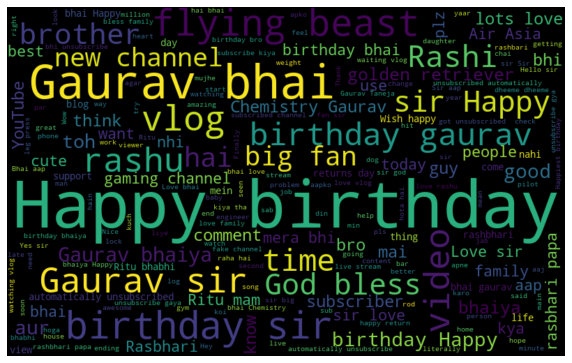

In [ ]:
save_wordcloud(comments_data['clean_comment'], search_query)

## Sentiment analysis on Comments



In [ ]:
## How to use BERT
# https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb

In [ ]:
## Getting BERT
# temp = list(map(lambda x: len(x)==0, comments_data['clean_comment']))

nlp = pipeline("sentiment-analysis")

def get_sentiment(s):
  try:
    result = nlp(s)[0]
  except:
    result = {'label': 'POSITIVE', 'score': 0.0}
  return result

In [ ]:
start_time = time.time()
# temp = list(map(lambda x: get_sentiment(x), comments_data['clean_comment']))
with Pool(processes=6) as p:
    temp=list(p.imap(get_sentiment, tqdm(comments_data['clean_comment'])))
print("Time Taken:", time.time()-start_time)







 92%|█████████▏| 148326/160834 [1:33:16<09:26, 22.06it/s]





 92%|█████████▏| 148356/160834 [1:33:17<09:02, 23.01it/s]





 92%|█████████▏| 148387/160834 [1:33:18<08:42, 23.83it/s]





 92%|█████████▏| 148413/160834 [1:33:20<09:41, 21.37it/s]





 92%|█████████▏| 148445/160834 [1:33:21<09:19, 22.14it/s]





 92%|█████████▏| 148473/160834 [1:33:22<09:15, 22.27it/s]





 92%|█████████▏| 148498/160834 [1:33:24<10:05, 20.38it/s]





 92%|█████████▏| 148526/160834 [1:33:25<10:10, 20.17it/s]





 92%|█████████▏| 148554/160834 [1:33:26<09:12, 22.21it/s]





 92%|█████████▏| 148585/160834 [1:33:28<09:50, 20.74it/s]





 92%|█████████▏| 148615/160834 [1:33:29<09:24, 21.63it/s]





 92%|█████████▏| 148647/160834 [1:33:31<09:18, 21.81it/s]





 92%|█████████▏| 148672/160834 [1:33:32<10:08, 19.98it/s]





 92%|█████████▏| 148705/160834 [1:33:33<09:39, 20.94it/s]





 92%|█████████▏| 148740/160834 [1:33:35<08:46, 22.95it/s]





 93%|█████████▎| 148776/160834 [1:33:36<08:24, 23

Time Taken: 6073.540217876434


In [ ]:
comments_data['label'] = list(map(lambda x: x['label'], temp))
comments_data['score'] = list(map(lambda x: x['score'], temp))

In [ ]:
## Save the data
comments_data.to_pickle(root_path+'results_sentiment.pickle')

In [ ]:
Counter(comments_data.label)

Counter({'NEGATIVE': 62868, 'POSITIVE': 97966})

In [ ]:
comments_data['likecount_score'] = comments_data['likecount']*comments_data['score']
## get dislikes count and then add like counts and subtract dislike counts
# comments_data['dislikecount_score'] = comments_data['dislikecount']*comments_data['score']

sent_agg_data = comments_data.rename(columns={"song": "title"}).groupby(['title', 'label'])['score', 'likecount_score'].agg({
    'score':[('count', lambda x: sum(x))], 
    'likecount_score':[('count_likes', lambda x: sum(x))]
  })
sent_agg_data.columns = sent_agg_data.columns.droplevel(0)
sent_agg_data = sent_agg_data.reset_index()
sent_agg_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,title,label,count,count_likes
0,3 Generations Racing... Who will Win ?,NEGATIVE,4596.244361,13209.917789
1,3 Generations Racing... Who will Win ?,POSITIVE,3380.431468,5281.800445
2,Car mein Yeh kaise aayi ?? 😨,NEGATIVE,3545.776054,15130.918834
3,Car mein Yeh kaise aayi ?? 😨,POSITIVE,4234.426362,9485.024075
4,Daughter does Dad&#39;s makeup..,NEGATIVE,2452.018216,11415.274365
5,Daughter does Dad&#39;s makeup..,POSITIVE,2779.117140,11127.262024
6,Going for my Exit Formalities with the Company,NEGATIVE,2591.900449,17552.587578
7,Going for my Exit Formalities with the Company,POSITIVE,2778.433315,8124.133139
8,IIT Chemistry vs BSc Chemistry | OP,NEGATIVE,3114.528808,18249.698829
9,IIT Chemistry vs BSc Chemistry | OP,POSITIVE,10148.155263,9587.338845


In [ ]:
sent_agg_data.to_csv(root_path+'results_sentiment.csv')

## NER by StanfordNLP

In [ ]:
stanza.download('en', processors='tokenize,ner')
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,ner')

2020-07-20 21:03:40 INFO: Downloading these customized packages for language: en (English)...
| Processor       | Package   |
-------------------------------
| tokenize        | ewt       |
| ner             | ontonotes |
| forward_charlm  | 1billion  |
| backward_charlm | 1billion  |

2020-07-20 21:04:40 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-07-20 21:04:40 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2020-07-20 21:04:40 INFO: Use device: gpu
2020-07-20 21:04:40 INFO: Loading: tokenize
2020-07-20 21:04:56 INFO: Loading: ner
2020-07-20 21:04:57 INFO: Done loading processors!


In [ ]:
def find_entity(s, ent_type='PERSON'):
  "Finds entity from the string"
  entities = nlp_stanza(s).ents
  people = set(list(map(lambda e: e.text if e.type==ent_type else '', entities)))-{''}
  return people

In [ ]:
## Getting the song singer
for ent_type in ['PERSON', 'ORG', 'LOC']:
  title_person = list(map(lambda x: find_entity(x, ent_type=ent_type), search_data['title']))
  descrp_person = list(map(lambda x: find_entity(x, ent_type=ent_type), search_data['description']))
  search_data[ent_type] = [title_person[i].union(descrp_person[i])  for i in range(len(descrp_person))]

In [ ]:
## Get the Frequency of person, organization & location
from functools import reduce
person_pmf = Counter(reduce(lambda a,b : a+b,list(map(lambda x: list(x), search_data['PERSON']))))
org_pmf = Counter(reduce(lambda a,b : a+b,list(map(lambda x: list(x), search_data['ORG']))))
loc_pmf = Counter(reduce(lambda a,b : a+b,list(map(lambda x: list(x), search_data['LOC']))))

print('Person Frequency', '\n', person_pmf)
print('Organization Frequency', '\n', org_pmf)
print('Location Frequency', '\n', loc_pmf)

Person Frequency 
 Counter({'Gaurav': 15, 'Rashi': 6, 'Ritu': 5, 'Rasbhari Ke Papa': 3, 'Papa': 3, 'Instagram': 2, 'Dheeme Dheeme': 1, 'Dad&#39': 1, 'Bhuvan': 1, 'Peasee Papaaa': 1, 'Ram Sam Laaa..': 1, 'dikhana': 1, 'Dhruv Rathee': 1, 'Gaurav Taneja': 1, 'Chicklu': 1, 'She Sang the &quot': 1, 'Dada': 1, 'Dadi': 1, 'Mumma': 1})
Organization Frequency 
 Counter({'The Derma co': 1, 'Company': 1, 'Health and Fitness': 1, 'Mamaearth': 1, 'PMO': 1, 'Air Asia Airlines': 1, 'Sony India': 1, 'AirAsia Airline': 1})
Location Frequency 
 Counter()


In [ ]:
## Save the data
file = open(root_path+'pmf.pkl','wb')
pickle.dump(person_pmf, file)
pickle.dump(org_pmf, file)
pickle.dump(loc_pmf, file)
file.close()

# file = open(root_path+'pmf.pkl','rb')
# person_pmf = pickle.load(file)
# org_pmf = pickle.load(file)
# loc_pmf = pickle.load(file)
# file.close()
# print('Person Frequency', '\n', person_pmf)
# print('Organization Frequency', '\n', org_pmf)
# print('Location Frequency', '\n', loc_pmf)

In [ ]:
search_data.to_pickle(root_path+'search_results_NER.pickle')

In [ ]:
search_data

,videoId,title,description,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,PERSON,ORG,LOC
1,fHDhsL-w2Ko,Rashi finally does the &#39; Dheeme Dheeme &#3...,Vlog # 137 https://bit.ly/2C6n9h9 The Derma co...,484740,117393,1215,0,5195,"{Rashi, Dheeme Dheeme}",{The Derma co},{}
2,zqNSKl2xpYU,No Phone | No TV from now on,Vlog # 137 Gaming channel https://www.youtube....,2032617,206133,2412,0,6869,"{Gaurav, Ritu}",{},{}
3,7m72_3Vp9ew,Rashi got a New Friend and She Forgot Us,Vlog # 136 join us LIVE https://www.youtube.co...,1861426,174318,1832,0,16044,"{Rashi, Gaurav, Ritu}",{},{}
4,rKyvj-9MzOo,Rashi. went out First time after Lockdown,Vlog # 135 went out with rashii after soo loon...,2425361,223512,2320,0,10197,"{Gaurav, Ritu}",{},{}
5,PeBuyDAycck,Making the Original Cover with Rasbhari,Vlog # 134 PubG stream on https://www.youtube....,1977474,194419,2497,0,9474,"{Gaurav, Ritu}",{},{}
6,pGCLdH2b5r4,Going for my Exit Formalities with the Company,Vlog # 133 LIVE STREAM https://www.youtube.com...,2880992,229593,2493,0,7044,{Rashi},{Company},{}
7,GQMYYtK8eWM,IIT Chemistry vs BSc Chemistry | OP,Vlog # 133 Exhibit magazine. vote for me in th...,2102352,191978,2802,0,16126,{},{},{}
8,w3sxAN8kQ1Y,Daughter does Dad&#39;s makeup..,Vlog # 132 vote for me in Health and Fitness c...,1961013,193587,2240,0,6682,{Dad&#39},{Health and Fitness},{}
9,PxxNf_KQG04,The Struggling Beauty Blogger !!,Vlog # 120 uploaded this vlog from hotspot. wi...,2159667,206748,2518,0,7888,{Gaurav},{},{}
10,tPJdtpLQfMM,Papa Vs Rasbhari Dance off Challenge,Vlog # 131 @rasbharikepapa doing our first LIV...,2299516,212016,2143,0,9473,{Bhuvan},{},{}
